In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import zscore
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
import warnings
warnings.filterwarnings( "ignore")

In [39]:
df = pd.read_csv('/content/Twitter A_B testing.csv')

In [4]:
df.head()

,treatment,company_size,campaign_spend,campaign_budget
0,False,small,10.4477,3.9035
1,False,medium,3.7776,1.9872
2,False,medium,46.1880,55.4523
3,False,small,6.6271,6.5136
4,False,small,92.3405,83.1018


In [5]:
# Inspect the data
# checking the shape

df.shape

(15474, 4)

In [6]:
#viewing the columns

df.columns


Index(['treatment', 'company_size', 'campaign_spend', 'campaign_budget'], dtype='object')

In [7]:
#seeing if there are any duplicates

df.duplicated().sum()

np.int64(0)

In [8]:
print("\nDataFrame Info:")
display(df.info())


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15474 entries, 0 to 15473
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   treatment        15474 non-null  bool   
 1   company_size     15474 non-null  object 
 2   campaign_spend   15474 non-null  float64
 3   campaign_budget  15474 non-null  float64
dtypes: bool(1), float64(2), object(1)
memory usage: 377.9+ KB


None

In [9]:
# Check unique values in 'company_size'

# df['company_size'].unique()
df['company_size'].value_counts()

,count
company_size,
small,8901
large,5146
medium,1427


In [10]:
print("\nMissing values per column:")
display(df.isnull().sum())


Missing values per column:


,0
treatment,0
company_size,0
campaign_spend,0
campaign_budget,0


In [11]:
df.describe()

,campaign_spend,campaign_budget
count,1.547400e+04,1.547400e+04
mean,4.903037e+03,5.772614e+03
std,6.516692e+04,9.903381e+04
min,3.595000e-01,9.190000e-02
25%,1.517812e+01,1.279290e+01
50%,5.009005e+01,4.881625e+01
75%,2.365468e+02,2.523155e+02
max,5.289217e+06,1.024289e+07


In [12]:
# Add a calculated field for overspending
df['overspend'] = df['campaign_spend'] - df['campaign_budget']
df['overspend_percent'] = df['overspend'] / df['campaign_budget'] * 100
df['overspent_flag'] = df['overspend_percent'] > 1
df['percent_budget_spent'] = df['campaign_spend'] / df['campaign_budget'] * 100

# Separate data into treatment and control groups
control_group = df[df['treatment'] == False]
treatment_group = df[df['treatment'] == True]


# Display the first few rows with the new column
display(df.head())

,treatment,company_size,campaign_spend,campaign_budget,overspend,overspend_percent,overspent_flag,percent_budget_spent
0,False,small,10.4477,3.9035,6.5442,167.649545,True,267.649545
1,False,medium,3.7776,1.9872,1.7904,90.096618,True,190.096618
2,False,medium,46.1880,55.4523,-9.2643,-16.706791,False,83.293209
3,False,small,6.6271,6.5136,0.1135,1.742508,True,101.742508
4,False,small,92.3405,83.1018,9.2387,11.117328,True,111.117328


In [13]:
# Separate numeric and categorical variables
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df.select_dtypes(include='object').columns.tolist()
boolean_cols = df.select_dtypes(include='bool').columns.tolist() # Include boolean as a separate category

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)
print("Boolean columns:", boolean_cols)

Numeric columns: ['campaign_spend', 'campaign_budget', 'overspend', 'overspend_percent', 'percent_budget_spent']
Categorical columns: ['company_size']
Boolean columns: ['treatment', 'overspent_flag']


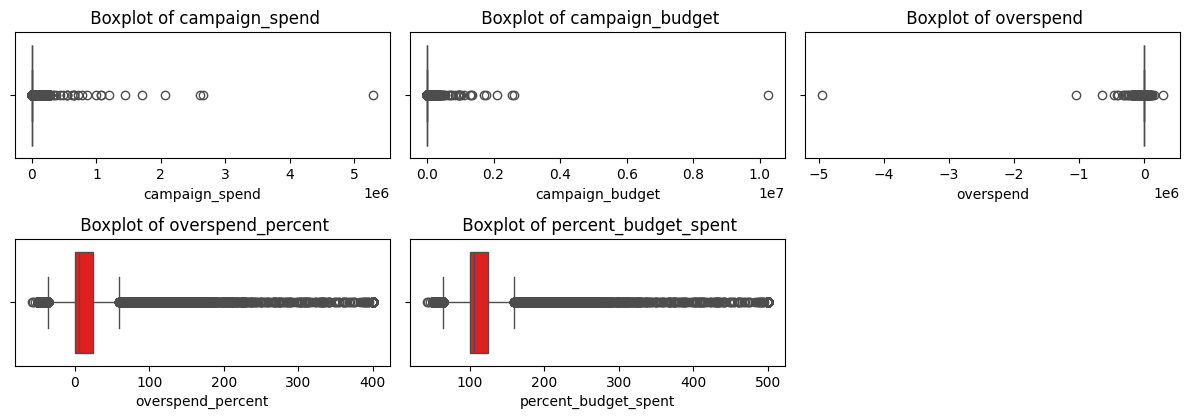

In [14]:
# checking if any outliers are present

plt.figure(figsize = (12,8))
# feature_list = df_num.columns # Corrected: Use the list of numeric column names
feature_list = numeric_cols

for i in range(len(feature_list)):
  plt.subplot(4, 3, i + 1)
  sns.boxplot(x=df[feature_list[i]],color='r'); # Corrected: Access column from original df
  plt.title(' Boxplot of {}'.format(feature_list[i]))
  plt.tight_layout()
plt.show() # Added to display the plots

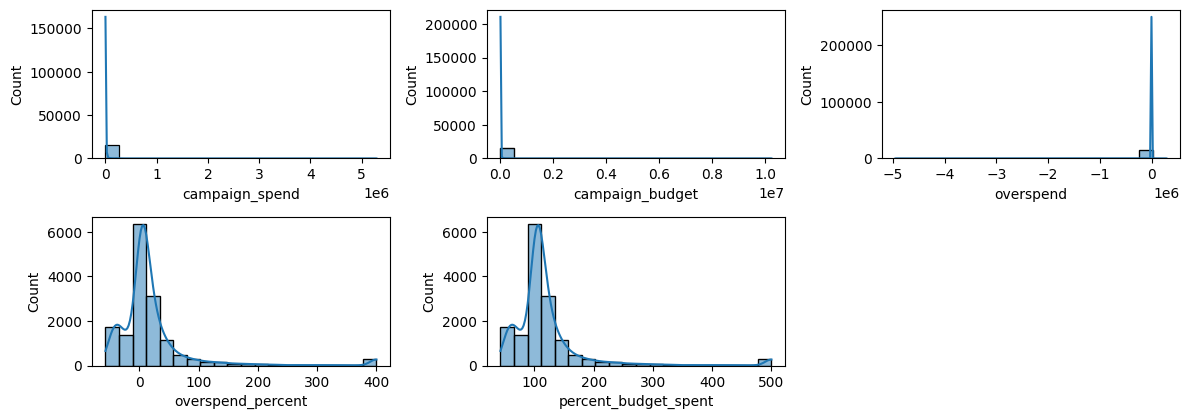

In [15]:
# for numerical values

plt.figure(figsize = (12,8))
# feature_list = df_num.columns # Corrected: Use the list of numeric column names
feature_list = numeric_cols

for i in range(len(feature_list)):
  plt.subplot(4, 3, i + 1)
  sns.histplot(x=df[feature_list[i]], kde=True, bins =20); # Corrected: Access column from original df and use histplot
  plt.tight_layout()
plt.show() # Added to display the plots

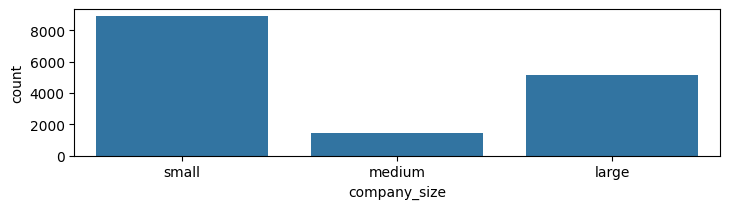

In [16]:
# for categorical values

plt.figure(figsize = (14,12))
# feature_list = df_cat.columns # Corrected: Use the list of categorical column names
feature_list = categorical_cols
for i in range(len(feature_list)):
    plt.subplot(6, 2, i + 1)
    sns.countplot(x = df[feature_list[i]], data = df) # Corrected: Access column from original df and use data=df
    plt.tight_layout()
plt.show() # Added to display the plots

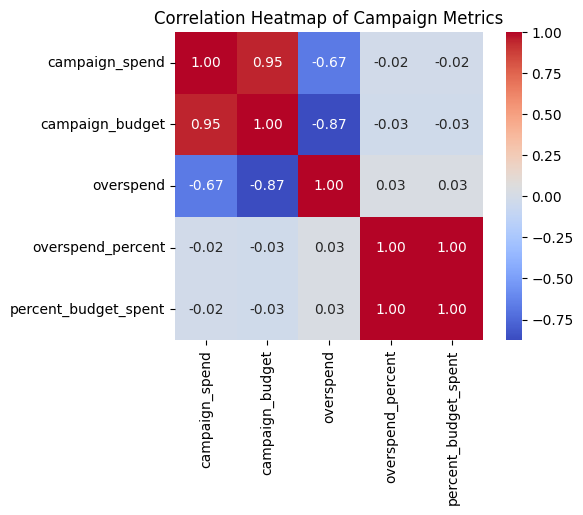

In [17]:
# checking correlation between variables

# Select numerical columns
corr_data = df[['campaign_spend', 'campaign_budget', 'overspend', 'overspend_percent', 'percent_budget_spent']]

# Calculate correlation matrix
corr_matrix = corr_data.corr()

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Heatmap of Campaign Metrics')
plt.show()

<Figure size 1000x600 with 0 Axes>

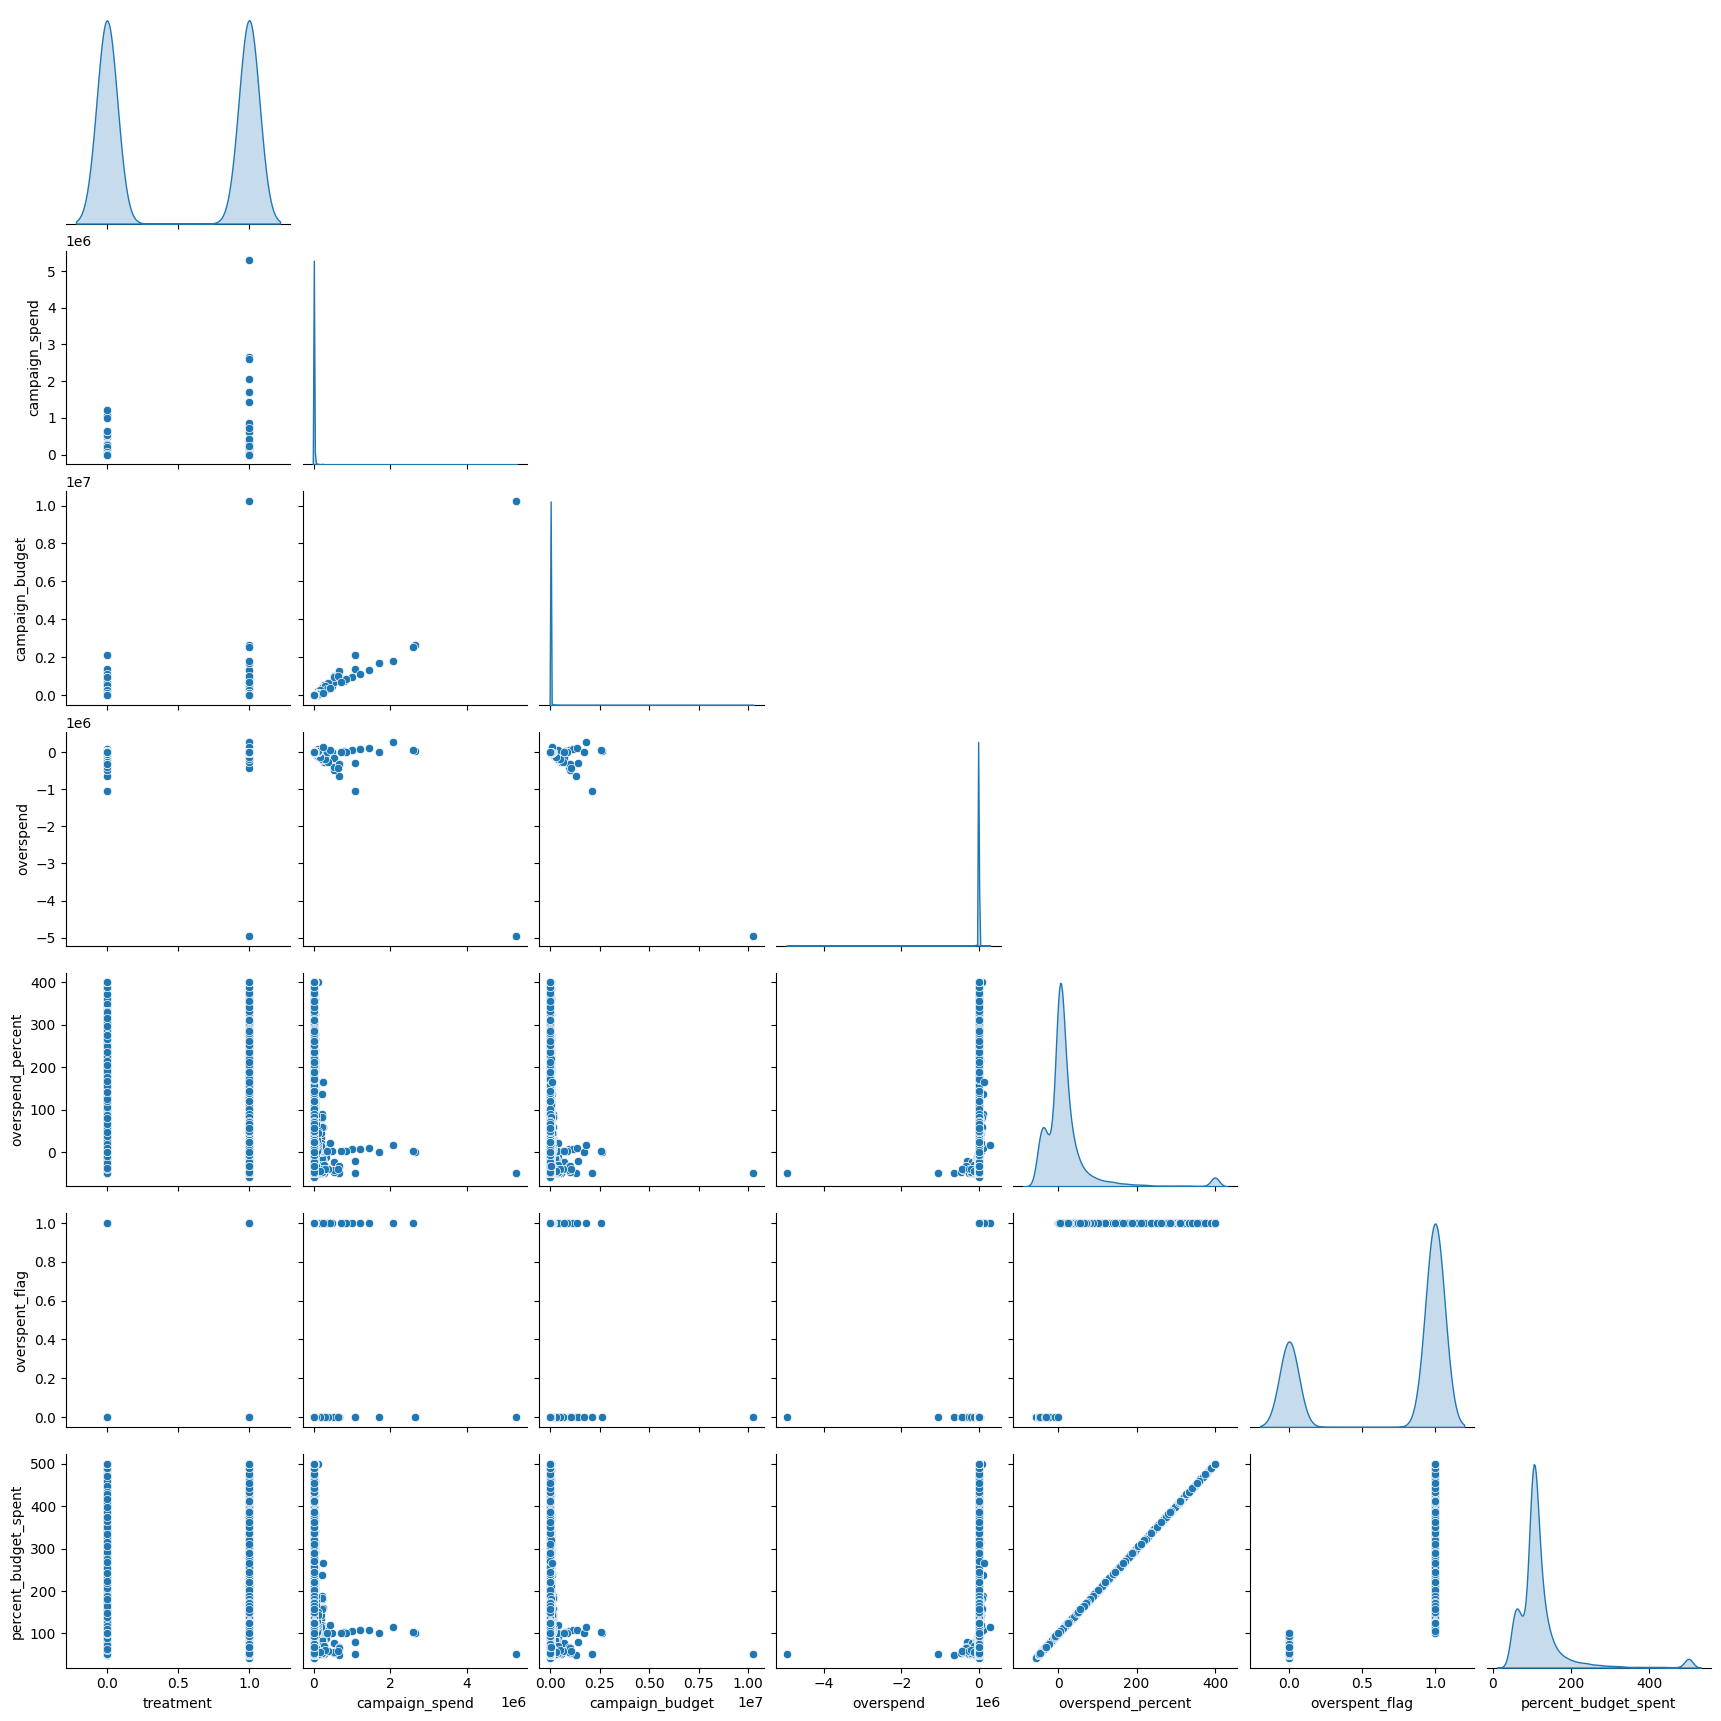

In [18]:
plt.figure(figsize = (10,6))
sns.pairplot(df,diag_kind='kde',corner=True);
plt.show()

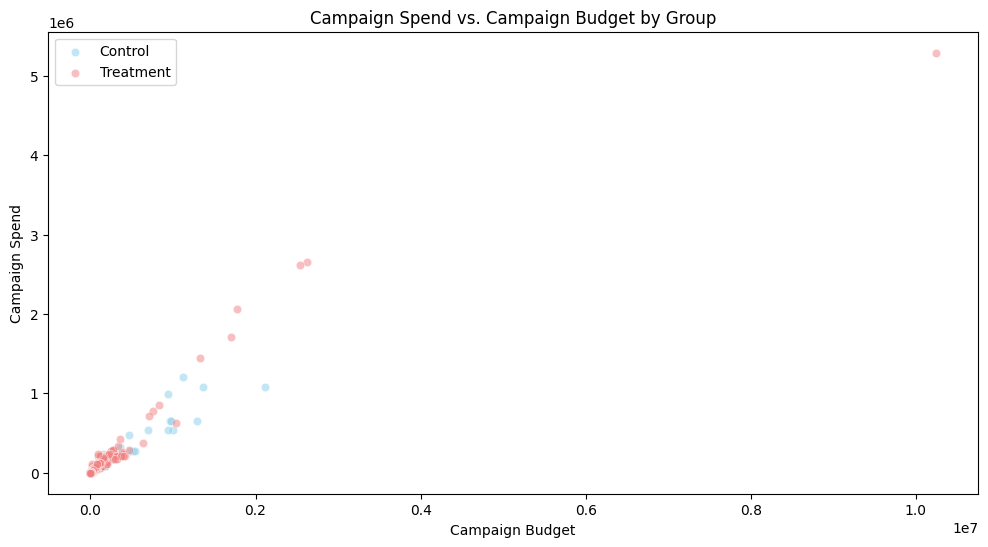

In [19]:
# Visualize the relationship between campaign_spend and campaign_budget for each group
plt.figure(figsize=(12, 6))
sns.scatterplot(data=control_group, x='campaign_budget', y='campaign_spend', alpha=0.5, label='Control', color='skyblue')
sns.scatterplot(data=treatment_group, x='campaign_budget', y='campaign_spend', alpha=0.5, label='Treatment', color='lightcoral')
plt.title('Campaign Spend vs. Campaign Budget by Group')
plt.xlabel('Campaign Budget')
plt.ylabel('Campaign Spend')
plt.legend()
plt.show()

In [20]:
# Perform independent samples t-test on 'overspend'
ttest_result = stats.ttest_ind(treatment_group['overspend'], control_group['overspend'])

print("Independent Samples t-test results for Overspend:")
print(f"Test Statistic: {ttest_result.statistic:.4f}")
print(f"P-value: {ttest_result.pvalue:.4f}")

# Interpret the results
alpha = 0.05
if ttest_result.pvalue < alpha:
    print("\nResult: The difference in overspend between the treatment and control groups is statistically significant.")
    print("Conclusion: The new impression-based ad product likely had an impact on overspending.")
else:
    print("\nResult: The difference in overspend between the treatment and control groups is not statistically significant.")
    print("Conclusion: There is not enough evidence to conclude that the new impression-based ad product had a significant impact on overspending.")

# Optional: Compare mean overspend for each group
mean_overspend_control = control_group['overspend'].mean()
mean_overspend_treatment = treatment_group['overspend'].mean()

print(f"\nMean Overspend (Control Group): {mean_overspend_control:.2f}")
print(f"Mean Overspend (Treatment Group): {mean_overspend_treatment:.2f}")

Independent Samples t-test results for Overspend:
Test Statistic: -0.5209
P-value: 0.6025

Result: The difference in overspend between the treatment and control groups is not statistically significant.
Conclusion: There is not enough evidence to conclude that the new impression-based ad product had a significant impact on overspending.

Mean Overspend (Control Group): -690.98
Mean Overspend (Treatment Group): -1047.99


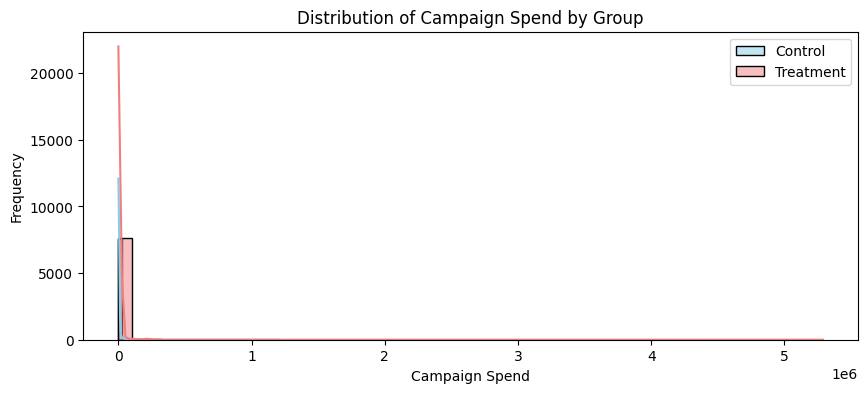

In [21]:
# Separate data into treatment and control groups
control_group = df[df['treatment'] == False]
treatment_group = df[df['treatment'] == True]

# Plot distributions of campaign_spend
plt.figure(figsize=(10, 4))
sns.histplot(control_group['campaign_spend'], kde=True, label='Control', color='skyblue', bins=50)
sns.histplot(treatment_group['campaign_spend'], kde=True, label='Treatment', color='lightcoral', bins=50)
plt.title('Distribution of Campaign Spend by Group')
plt.xlabel('Campaign Spend')
plt.ylabel('Frequency')
plt.legend()
plt.show()

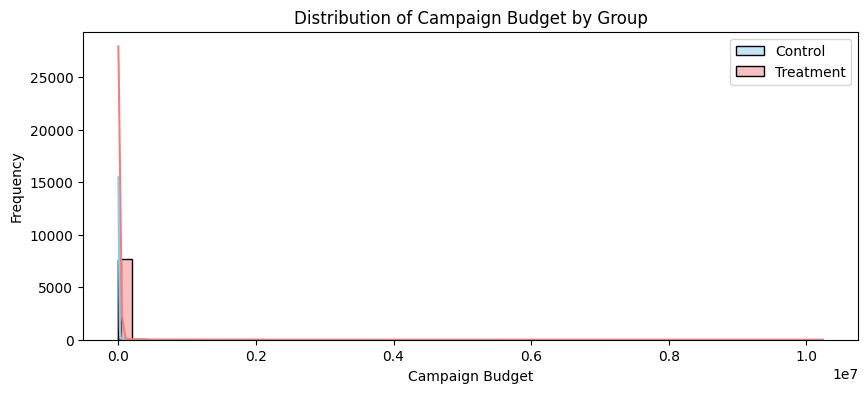

In [22]:
# Plot distributions of campaign_budget
plt.figure(figsize=(10, 4))
sns.histplot(control_group['campaign_budget'], kde=True, label='Control', color='skyblue', bins=50)
sns.histplot(treatment_group['campaign_budget'], kde=True, label='Treatment', color='lightcoral', bins=50)
plt.title('Distribution of Campaign Budget by Group')
plt.xlabel('Campaign Budget')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### 1-: How many campaigns have overspent of greater than 1% of their budget in the control group? In the treatment group?


In [23]:
# Count campaigns with overspend greater than 1% in the control group
control_overspent_count = control_group[control_group['overspent_flag']].shape[0]

# Count campaigns with overspend greater than 1% in the treatment group
treatment_overspent_count = treatment_group[treatment_group['overspent_flag']].shape[0]

print(f"Number of campaigns with overspend > 1% in the Control Group: {control_overspent_count}")
print(f"Number of campaigns with overspend > 1% in the Treatment Group: {treatment_overspent_count}")

Number of campaigns with overspend > 1% in the Control Group: 5716
Number of campaigns with overspend > 1% in the Treatment Group: 5180


2-: Was the new product effective at reducing overspend, and was it more or less effective depending on the company size? Put together an analysis describing how the treatment affected overspend.


In [24]:
# Analyze overspend by treatment group and company size

# Overall comparison of overspend
avg_overspend = df.groupby('treatment')['overspend_percent'].mean().reset_index()
avg_overspend

,treatment,overspend_percent
0,False,25.32255
1,True,17.60635


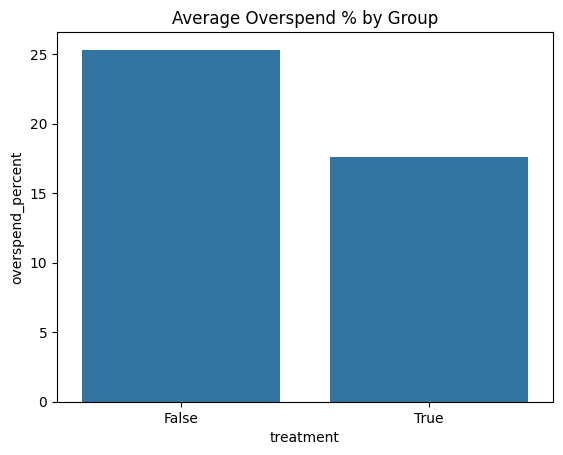

In [25]:
sns.barplot(data=avg_overspend, x='treatment', y='overspend_percent')
plt.title('Average Overspend % by Group')
plt.show()

In [26]:
# By company size
overspend_by_size = df.groupby(['treatment', 'company_size'])['overspend_percent'].mean().reset_index()
overspend_by_size

,treatment,company_size,overspend_percent
0,False,large,12.293655
1,False,medium,4.557030
2,False,small,37.064162
3,True,large,3.263995
4,True,medium,5.144382
5,True,small,27.096085


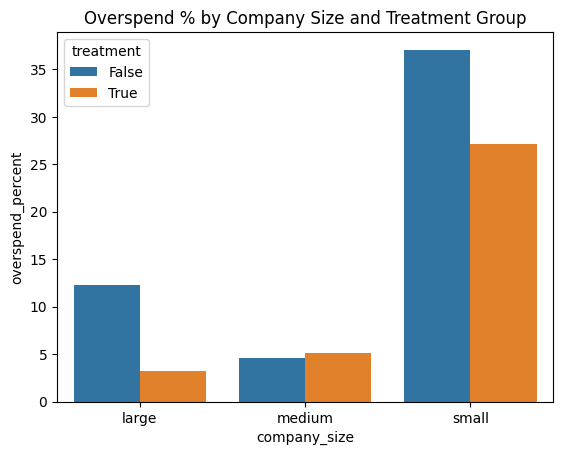

In [27]:
sns.barplot(data=overspend_by_size, x='company_size', y='overspend_percent', hue='treatment')
plt.title('Overspend % by Company Size and Treatment Group')
plt.show()

In [28]:
control_overspend = df[df['treatment'] == False]['overspend_percent']
treatment_overspend = df[df['treatment'] == True]['overspend_percent']

t_stat, p_value = stats.ttest_ind(control_overspend, treatment_overspend, equal_var=False)
print("T-statistic value: ", t_stat)
print("P-Value: ", p_value)

if(p_value < 0.05):
  print("Reject the null hypothesis")
else:
  print("Failed to reject the null hypothesis")


T-statistic value:  6.676538402129285
P-Value:  2.5300672747236123e-11
Reject the null hypothesis


### 3-: A product manager on the team is concerned that certain advertisers in the treatment group are entering lower budgets because they are wary of the new product. Provide some evidence to support their suspicions, or show that any differences in budgets are likely due to random fluctuations.

In [29]:
# Compare campaign budgets between treatment and control groups

# Calculate mean campaign budget for each group
mean_budget_control = control_group['campaign_budget'].mean()
mean_budget_treatment = treatment_group['campaign_budget'].mean()

print(f"Mean Campaign Budget (Control Group): {mean_budget_control:.2f}")
print(f"Mean Campaign Budget (Treatment Group): {mean_budget_treatment:.2f}")

# Perform independent samples t-test on campaign_budget
ttest_budget_result = stats.ttest_ind(treatment_group['campaign_budget'], control_group['campaign_budget'])

print("\nIndependent Samples t-test results for Campaign Budget:")
print(f"Test Statistic: {ttest_budget_result.statistic:.4f}")
print(f"P-value: {ttest_budget_result.pvalue:.4f}")



Mean Campaign Budget (Control Group): 4641.83
Mean Campaign Budget (Treatment Group): 6902.23

Independent Samples t-test results for Campaign Budget:
Test Statistic: 1.4197
P-value: 0.1557


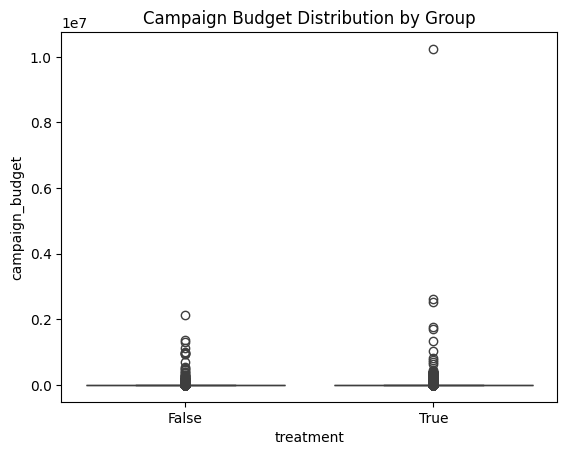

In [30]:
# Visual comparison
sns.boxplot(data=df, x='treatment', y='campaign_budget')
plt.title('Campaign Budget Distribution by Group')
plt.show()

4-: What is the average overspend percentage for campaigns in both the control and treatment groups?


In [31]:
# Calculate and print the average overspend percentage for each group
average_overspend_percent = df.groupby('treatment')['overspend_percent'].mean()

print("Average Overspend Percentage by Group:")
print(average_overspend_percent)

Average Overspend Percentage by Group:
treatment
False    25.32255
True     17.60635
Name: overspend_percent, dtype: float64


5-:How does the click-through rate (CTR) compare between the traditional click-based model and the impression-based model?

In [32]:
# The DataFrame does not include include click or impression data, so click-through rate (CTR)
# cannot be calculated from the provided information. To perform this analysis, additional click
# and impression columns would be required.

# CTR is usually calculated as:

# CTR = Number of Clicks / Number of Impressions

print("CTR data not available in provided dataset.")

CTR data not available in provided dataset.


6-: What demographic factors (e.g., industry, company size) correlate with higher overspending rates in both groups?


Average Overspend Percentage by Company Size (Control Group):


,overspend_percent
company_size,
large,12.293655
medium,4.557030
small,37.064162



Average Overspend Percentage by Company Size (Treatment Group):


,overspend_percent
company_size,
large,3.263995
medium,5.144382
small,27.096085


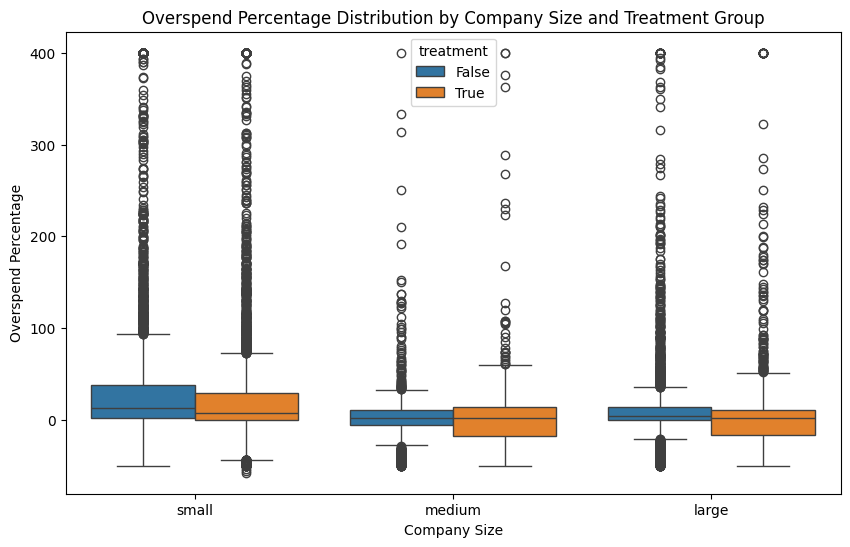

In [33]:
# Analyze overspending rates by company size for both treatment and control groups

print("Average Overspend Percentage by Company Size (Control Group):")
display(control_group.groupby('company_size')['overspend_percent'].mean())

print("\nAverage Overspend Percentage by Company Size (Treatment Group):")
display(treatment_group.groupby('company_size')['overspend_percent'].mean())

# Visualize the distribution of overspend percentage by company size and treatment group
plt.figure(figsize=(10, 6))
sns.boxplot(x='company_size', y='overspend_percent', hue='treatment', data=df)
plt.title('Overspend Percentage Distribution by Company Size and Treatment Group')
plt.xlabel('Company Size')
plt.ylabel('Overspend Percentage')
plt.show()

# Although 'company_size' is categorical, we can look at the means to understand the relationship.
# Correlation is typically for numerical variables, but grouping by a categorical variable and
# comparing means serves a similar purpose in identifying relationships.

7-: How do the overall engagement metrics (likes, retweets, replies) differ between the two advertising models?


In [34]:
# Note: Engagement metrics such as likes, retweets, and replies are not included in the provided dataset.
# Further analysis would require these additional features.

print("Engagement metrics (likes, retweets, replies) not available in provided dataset.")

Engagement metrics (likes, retweets, replies) not available in provided dataset.


8-: Is there a statistically significant difference in the percentage of budget spent between the control and treatment groups?


In [35]:
df['percent_budget_spent'] = df['campaign_spend'] / df['campaign_budget'] * 100

control_spent = df[df['treatment'] == False]['percent_budget_spent']
treatment_spent = df[df['treatment'] == True]['percent_budget_spent']

t_stat, p_value = stats.ttest_ind(control_spent, treatment_spent, equal_var=False)
print("T-statistic value: ", t_stat)
print("P-Value: ", p_value)

if(p_value < 0.05):
  print("Reject the null hypothesis")
else:
  print("Failed to reject the null hypothesis")

T-statistic value:  6.676538402129291
P-Value:  2.5300672747235292e-11
Reject the null hypothesis


9-: Does company size have a significant impact on the overspend percentage in both control and treatment groups?


In [36]:
from scipy.stats import f_oneway
company_sizes = df['company_size'].unique()
for size in company_sizes:
    subset = df[df['company_size'] == size]['overspend_percent']
    print(f"Company size: {size}, Sample size: {len(subset)}")

groups = [df[df['company_size'] == size]['overspend_percent'] for size in company_sizes]

f_stat, p_value = f_oneway(*groups)
print(f"One-Way ANOVA: F-statistic={f_stat}, p-value={p_value}")

if p_value < 0.05:
    print("Reject the null hypothesis. Company size has a significant impact on overspend percentage.")
else:
    print("Failed to reject the null hypothesis. Company size does not have a significant impact on overspend percentage.")

Company size: small, Sample size: 8901
Company size: medium, Sample size: 1427
Company size: large, Sample size: 5146
One-Way ANOVA: F-statistic=228.23029205524756, p-value=2.0650160707301405e-98
Reject the null hypothesis. Company size has a significant impact on overspend percentage.


10-: Is the variance in campaign spend significantly different between the control and treatment groups?


In [37]:
control_var = np.var(control_spent, ddof=1)
treatment_var = np.var(treatment_spent, ddof=1)

f_stat = control_var / treatment_var
print(f"Variance control: {control_var}")
print(f"Variance treatment: {treatment_var}")
print(f"F-statistic: {f_stat}")


Variance control: 5456.991956144386
Variance treatment: 4876.905559329755
F-statistic: 1.118945587475012


In [38]:
# Chi-Square Test: Treatment vs. Overspend Status,
# Test whether overspending (Yes/No) is dependent on treatment group.

# Create contingency table
contingency = pd.crosstab(df['treatment'], df['overspent_flag'])

# Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency)

print(f"Chi-Square Statistic: {chi2}")
print(f"P-value: {p}")

if p < 0.05:
    print("There is a statistically significant association between treatment and overspending status.")
else:
    print("There is no statistically significant association between treatment and overspending status.")

Chi-Square Statistic: 90.67033815733254
P-value: 1.6971852734360634e-21
There is a statistically significant association between treatment and overspending status.
